In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166691 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
keep = [
    'LinNegCD34lowCD164high',
    'HSC',
    'LinNegCD34PosCD164Pos',
    'FB',
    'Refined.HSC',
]

idx = adata.obs[adata.obs['cell_type'].isin(keep)].index

pdf = adata[idx, :].copy()
pdf.obs['broad_type'] = np.where(pdf.obs['cell_type'] == 'FB', 'Fibroblast', 'HSC')
pdf


AnnData object with n_obs × n_vars = 58252 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat', 'broad_type'
    var: 'gene_name', 'ensembl

In [4]:
pdf.obs['broad_type'].value_counts()

broad_type
HSC           31666
Fibroblast    26586
Name: count, dtype: int64

In [5]:
sc.pp.filter_genes(pdf, min_counts=3)
sc.pp.filter_cells(pdf, min_counts=100)

sc.pp.normalize_total(pdf)
sc.pp.log1p(pdf)

sc.pp.combat(pdf, key='dataset')

# handle negatives
pdf.X = np.where(pdf.X < 0, 0, pdf.X)

sc.pp.highly_variable_genes(pdf)

print('done')


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


done


In [6]:
sc.tl.rank_genes_groups(pdf, 
                        groupby="broad_type",
                        method='wilcoxon',
                        corr_method='benjamini-hochberg',
                        pts=True,
                        key_added='deg',
                       )

print('Done')

Done


In [7]:
deg = sc.get.rank_genes_groups_df(pdf, 
                                  group=None,
                                  key='deg')

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,Fibroblast,ADAM2,203.184158,-0.542062,0.0,0.0,1.0,0.481115
1,Fibroblast,ZIC3,203.184158,-0.541245,0.0,0.0,1.0,0.624582
2,Fibroblast,TBC1D28,203.184158,-0.541239,0.0,0.0,1.0,0.624582
3,Fibroblast,PHOX2B,203.184158,-0.541245,0.0,0.0,1.0,0.624582
4,Fibroblast,R3HDML,203.184158,-0.541240,0.0,0.0,1.0,0.624582


In [8]:
sig = deg.copy()

pvals_adj = 0.05
logfoldchanges = 0.0
pct_nz_group = 0.9

sig = sig[~sig['names'].str.startswith("RP")]
sig = sig[~sig['names'].str.startswith("MT")]
sig = sig[sig['pvals_adj'] < pvals_adj]
sig = sig[sig['logfoldchanges'] > logfoldchanges]
sig = sig[sig['pct_nz_group'] > pct_nz_group]

print(sig['group'].value_counts())

sig.head()

group
HSC           181
Fibroblast    105
Name: count, dtype: int64


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
1917,Fibroblast,CFD,90.783409,0.241405,0.0,0.0,0.945159,0.976663
2115,Fibroblast,SERPING1,66.731842,0.171255,0.0,0.0,0.979087,0.978115
2132,Fibroblast,GSN,64.576836,0.186763,0.0,0.0,0.976755,0.980294
2136,Fibroblast,C1S,63.475861,0.170499,0.0,0.0,0.977808,0.975999
2182,Fibroblast,C1R,59.008514,0.176354,0.0,0.0,0.964154,0.975999


In [9]:
marker_genes = sig.groupby('group')['names'].agg(list).to_dict()
marker_genes.keys()

dict_keys(['Fibroblast', 'HSC'])

In [13]:
our = adata[adata.obs['dataset'] == "iHSC", :]
our

View of AnnData object with n_obs × n_vars = 8562 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [14]:
sc.pp.filter_genes(our, min_counts=3)
sc.pp.filter_cells(our, min_counts=100)

sc.pp.normalize_total(our)
sc.pp.log1p(our)
sc.pp.highly_variable_genes(our)
sc.tl.pca(our)
sc.pp.neighbors(our)
sc.tl.umap(our)

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:273: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_counts"] = number
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


       'TIMP1', 'FBLN1', 'C12orf57', 'EID1', 'VIM', 'RAC1', 'PRDX1', 'TPT1',
       'TMSB4X', 'SRP14', 'FTL', 'EIF1', 'EEF2'],
      dtype='object')
       'VCX3A', 'OR9I1', 'DEFB110', 'TGIF2-RAB5IF', 'LY6G6F-LY6G6D', 'SPANXN1',
       'MC4R', 'OR51I1', 'TVP23C-CDRT4', 'NME1-NME2', 'DIPK1C', 'PPAN-P2RY11',
       'SPDYE18', 'CD274', 'LTF', 'CATSPER1', 'SLC9A3', 'MCEMP1', 'UTY',
       'ATP8B4', 'PRKG1', 'MSRB3', 'NRIP1', 'USP15', 'HINT1', 'ACTB', 'HNRNPC',
       'UBB', 'PTEN', 'TUBA1B', 'EEF1G'],
      dtype='object')


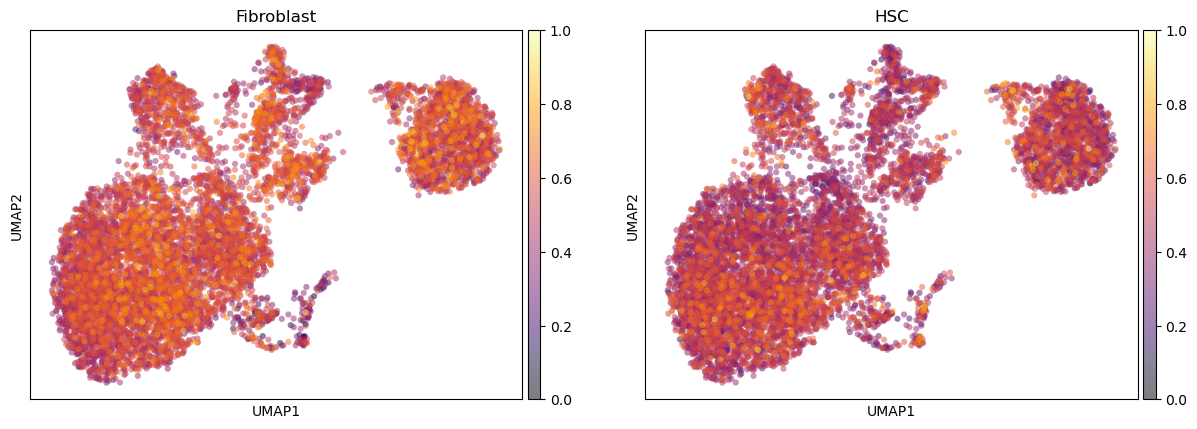

In [19]:
# score the gene sets
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

def filter_genes(gene_list, our):
    return [x for x in gene_list if x in pdf.var['gene_name'].values]

for k, v in marker_genes.items():
    
    gene_names = filter_genes(v, our)
    
    sc.tl.score_genes(our,
                      gene_list=gene_names, 
                      ctrl_size=len(gene_names),
                      n_bins=11,
                      score_name=k)
    
    # normalize the scores
    our.obs[k] = min_max(our.obs[k])
    

sc.pl.umap(our, 
       s=80,
       cmap='inferno',
       alpha=0.5,
       color=list(marker_genes.keys()))